In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
_FOLDER = "./data/"

In [2]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm

In [3]:
import os
print(os.listdir("data"))

['Drug_Features2.csv', 'Cell_Lines_Details.csv', 'Drug_Features.csv', 'Cell_Line_Features_PANCAN_simple_MOBEM.xlsx', 'Cell_Line_Features_PANCAN_simple_MOBEM.tsv', 'normalised_dose_response_data.csv']


### Cell_Lines_Details.csv

In [5]:
cell_lines = pd.read_csv(_FOLDER+'Cell_Lines_Details.csv')
cell_lines.shape

(1001, 13)

In [6]:
cell_lines.head()

,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\rResponse,GDSC\rTissue descriptor 1,GDSC\rTissue\rdescriptor 2,Cancer Type\r(matching TCGA label),Microsatellite \rinstability Status (MSI),Screen Medium,Growth Properties
0,A253,906794,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
3,BHY,753535,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
4,BICR10,1290724,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


In [7]:
cell_lines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Sample Name                               1001 non-null   object
 1   COSMIC identifier                         1001 non-null   int64 
 2   Whole Exome Sequencing (WES)              1001 non-null   object
 3   Copy Number Alterations (CNA)             1001 non-null   object
 4   Gene Expression                           1001 non-null   object
 5   Methylation                               1001 non-null   object
Response                             1001 non-null   object
Tissue descriptor 1                  1001 non-null   object
descriptor 2                  1001 non-null   object
(matching TCGA label)         826 non-null    object
instability Status (MSI)  986 non-null    object
 11  Screen Medium                             1001 non-nu

In [8]:
to_rename_columns = {"Drug\rResponse": 'Drug/Response', 
                 'GDSC\rTissue descriptor 1': "GDSC/Tissue descriptor 1",
                  'GDSC\rTissue\rdescriptor 2':'GDSC/Tissue\rdescriptor 2', 
                  'Cancer Type\r(matching TCGA label)':'Cancer Type/(matching TCGA label)',
                  'Microsatellite \rinstability Status (MSI)':'Microsatellite/instability Status (MSI)',
                 }
cell_lines.rename(columns = to_rename_columns, inplace=True)

In [9]:
columns_to_study =["Sample Name", "COSMIC identifier", "GDSC/Tissue descriptor 1", 
                   "Cancer Type/(matching TCGA label)", "Microsatellite/instability Status (MSI)",
                  "Screen Medium", "Growth Properties"]

print("Number of samples in the data set:", cell_lines.shape[0], "\n")
for col in columns_to_study:
    print("%s - unique values: %d " % (col, cell_lines[col].nunique()))

Number of samples in the data set: 1001 

Sample Name - unique values: 1001 
COSMIC identifier - unique values: 1001 
GDSC/Tissue descriptor 1 - unique values: 19 
Cancer Type/(matching TCGA label) - unique values: 31 
Microsatellite/instability Status (MSI) - unique values: 2 
Screen Medium - unique values: 2 
Growth Properties - unique values: 3 


In [10]:
cell_lines["Growth Properties"].value_counts()

Adherent         725
Suspension       244
Semi-Adherent     30
Name: Growth Properties, dtype: int64

In [11]:
cell_lines["Drug/Response"].value_counts()

Y    990
N     11
Name: Drug/Response, dtype: int64

In [12]:
cells_with_response = cell_lines[cell_lines["Drug/Response"]=="Y"]

In [13]:
#columns with NaN values
for col in cells_with_response.columns:
    number_null_values=cells_with_response[col].isnull().sum()
    if number_null_values>0:
        print(col, ":", number_null_values)

Cancer Type/(matching TCGA label) : 170
Microsatellite/instability Status (MSI) : 15


In [14]:
potential_features = ["Whole Exome Sequencing (WES)",
                      "Copy Number Alterations (CNA)",
                      "Gene Expression", 
                      "Methylation"]
for col in potential_features:
#     print(col, cells_with_response[col].nunique())
    print(cells_with_response[col].value_counts(), "\n")

Y    990
Name: Whole Exome Sequencing (WES), dtype: int64 

Y    985
N      5
Name: Copy Number Alterations (CNA), dtype: int64 

Y    962
N     28
Name: Gene Expression, dtype: int64 

Y    949
N     41
Name: Methylation, dtype: int64 



In [15]:
full_profiles= cells_with_response[(cells_with_response["Whole Exome Sequencing (WES)"]=="Y")
                    &(cells_with_response["Copy Number Alterations (CNA)"]=="Y")
                    &(cells_with_response["Gene Expression"]=="Y")
                    &(cells_with_response["Methylation"]=="Y")]
full_profiles.shape

(928, 13)

**Short observations:**
<br><br>1. the dataset **Cell_Lines_Details.csv** has 1001 samples, but only 990 has Y for "Drug\rResponse"
<br><br>2. For "Drug\rResponse" == Y, missing values can be found in:
<br><t>"Cancer Type\r(matching TCGA label)" - 170, "Microsatellite \rinstability Status (MSI)" -15
<br><br>3. Full profiles are available for 928 samples

### Cell_Line_Features_PANCAN_simple_MOBEM.tsv

In [16]:
cell_features = pd.read_csv(_FOLDER+"Cell_Line_Features_PANCAN_simple_MOBEM.tsv", sep="\t")
cell_features.shape

(1073, 1002)

In [17]:
cell_features.head()

,Unnamed: 0,1287381,924100,910924,687561,1287706,687452,906798,906797,906800,...,910545,1524416,971774,930083,909700,909701,753620,905965,1299061,1331040
0,ABCB1_mut,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABL2_mut,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACACA_mut,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACVR1B_mut,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACVR2A_mut,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
cell_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073 entries, 0 to 1072
Columns: 1002 entries, Unnamed: 0 to 1331040
dtypes: int64(1001), object(1)
memory usage: 8.2+ MB


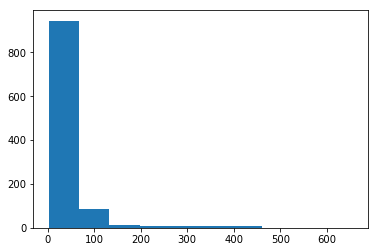

In [19]:
non_zeros = np.sum(cell_features.values!=0, axis=1)
plt.hist(non_zeros);

In [20]:
non_zeros.argmax()

288

In [21]:
cell_features.iloc[non_zeros.argmax(), :].value_counts()

1           655
0           346
TP53_mut      1
Name: 288, dtype: int64

In [22]:
common = set(cell_lines["COSMIC identifier"].unique()) - set(cell_features.columns[1:])
len(common)

1001

### Drug_Features.csv

In [4]:
drug_features = pd.read_csv(_FOLDER+'Drug_Features.csv')
drug_features.shape

(265, 5)

In [24]:
drug_features.head()

,Drug ID,Drug Name,Synonyms,Target,Target Pathway
0,1,Erlotinib,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",EGFR,EGFR signaling
1,3,Rapamycin,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",MTORC1,PI3K/MTOR signaling
2,5,Sunitinib,"Sutent, Sunitinib Malate, SU-11248","PDGFR, KIT, VEGFR, FLT3, RET, CSF1R",RTK signaling
3,6,PHA-665752,"PHA665752, PHA 665752",MET,RTK signaling
4,9,MG-132,"LLL cpd, MG 132, MG132","Proteasome, CAPN1",Protein stability and degradation


### normalised_dose_response_data.csv

In [5]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")
drug_curves.shape

(225384, 44)

In [6]:
drug_curves.head()

,Unnamed: 0,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,...,per_slope_change_7,slope_0,slope_1,slope_2,slope_3,slope_4,slope_5,slope_6,slope_7,slope_8
0,0,HDQ-P1,1290922,332,332_1290922,2,10.240,0,0.111111,0.222222,...,-2.14694,0.354085,-0.371905,0.069255,0.450075,-0.049503,-0.131784,0.246947,-1.239447,1.421566
1,1,HDQ-P1,1290922,257,257_1290922,2,10.240,0,0.111111,0.222222,...,-30.3283,-0.275239,0.163481,0.586129,0.180903,-0.221430,-0.349017,0.157822,0.087103,-2.554585
2,2,HDQ-P1,1290922,245,245_1290922,2,40.000,0,0.111111,0.222222,...,-0.618543,-0.394857,-0.615137,0.485215,-0.923687,0.466260,2.837371,-5.409070,-3.468825,-1.323207
3,3,HDQ-P1,1290922,155,155_1290922,2,0.512,0,0.111111,0.222222,...,1.14591,0.791510,-0.964611,1.238764,1.046952,-0.652559,-1.921061,-0.541266,-0.480877,-1.031916
4,4,HDQ-P1,1290922,192,192_1290922,2,16.000,0,0.111111,0.222222,...,1.53355,0.317413,0.044115,-0.604783,0.510820,-0.431190,0.575779,2.380415,-0.793585,-2.010587


In [8]:
print("Number of unique drugs:", drug_curves["DRUG_ID"].nunique())
print("Number of unique cancer cell lines:", drug_curves["COSMIC_ID"].nunique())

Number of unique drugs: 265
Number of unique cancer cell lines: 1074


In [267]:
drug_curves.groupby("CELL_LINE_NAME")[["COSMIC_ID"]].size()

CELL_LINE_NAME
201T        185
22RV1       223
23132-87    216
42-MG-BA    217
451Lu       221
           ... 
YT          258
ZR-75-30     91
huH-1       224
no-10       241
no-11       265
Length: 1074, dtype: int64

In [342]:
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

In [311]:
def show_response_curves(df, plots_in_row, plots_in_column, x_columns, y_columns, start_index=0, indexes=[],
                         fitting_function =None, fitting_parameters =None):
    
    fig = plt.figure(figsize=(14, 11))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    n_plots= plots_in_row*plots_in_column
    
    if len(indexes) ==0:
        start_finish = start_index+n_plots
        for n in range(start_index, start_finish):
            x = df.loc[n, x_columns]
            y = df.loc[n, y_columns]
            if n%n_plots == 0:
                i= n_plots
            else:
                i= n%n_plots
            
            ax = fig.add_subplot(plots_in_row, plots_in_column, i)
            ax.scatter(x,y)
            ax.set_title(str(ind)+"_"+str(df.loc[ind, "DRUG_ID"])+"_"+df.loc[ind, "CELL_LINE_NAME"]+"_"+str(n))
            ax.set_xlabel("Scaled dosage")
            ax.set_ylabel("Normalised response")
            if fitting_function:
                    ax2 = ax.twinx()
                    x2 = np.linspace(0, 1, 10)
                    fit_param =df.loc[ind, fitting_parameters]
                    y2 = fitting_function(x2, *fit_param)
                    ax2.plot(x2, y2, label= "R^2= %0.4f"% r2_score(y, y2))
                    ax2.legend() 
    else:
        
        try:
            for n, ind in list(enumerate(indexes)):
                x = df.loc[ind, x_columns]
                y = df.loc[ind, y_columns]
                if n%n_plots == 0:
                    i= n_plots
                else:
                    i= n%n_plots
                ax = fig.add_subplot(plots_in_row, plots_in_column, i)
                ax.scatter(x,y)
                ax.set_title(str(ind)+"_"+str(df.loc[ind, "DRUG_ID"])+"_"+df.loc[ind, "CELL_LINE_NAME"]+"_"+str(n))
                ax.set_xlabel("Scaled dosage")
                ax.set_ylabel("Normalised response")
                if fitting_function:
                    ax2 = ax.twinx()
                    x2 = np.linspace(0, 1, 10)
                    fit_param =df.loc[ind, fitting_parameters]
                    y2 = fitting_function(x2, *fit_param)
                    ax2.plot(x2, y2, label= "R^2= %0.4f"% r2_score(y, y2))
                    ax2.legend()
        except:
            print("ERROR: Number of indexes does not correspond to number of graphs to plot")
            
            
def plot_one(df, n, x_columns, y_columns, function_to_fit, function_parameters =[]):
#     plt.figure(figsize=(10, 8))
    loc_n = df.index[n]
    x = df.loc[loc_n, x_columns]
    y = df.loc[loc_n, y_columns]
    plt.scatter(x, y, label= "data")
    
    x2 = np.linspace(0, 1, 10)
    y2 = function_to_fit(x2, function_parameters[0], function_parameters[1])
    
    y_fitted = sigmoid(x, function_parameters[0], function_parameters[1])
    r2 = r2_score(y, y_fitted)
    plt.plot(x2, y2, label = "sigmoid: R^2=%0.2f" % r2)
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.legend()
    plt.Text(r2)

In [343]:
def fit_column_sigmoid_4_param(df, indexes):
    
    r2_scores = np.zeros(len(indexes))
    X = df.loc[indexes, conc_columns].values.astype(np.float32)
    Y = df.loc[indexes, response_norm].values.astype(np.float32)
    fitting_parameters = [None]*len(indexes)
    
    for i in tqdm(range(len(indexes))):
        x = X[i, :]
        y = Y[i, :]
        try:
            r2_scores[i], fitting_parameters[i] = fit_curve_fit(sigmoid_4_param, x, y, parameters_guess= [max(y), np.median(x), 1, min(y)])
            
        except:
            #print(indexes[i])
            r2_scores[i] = 0
    return r2_scores, fitting_parameters

In [354]:
def filtering_before_fitting(df, first_columns_to_compare = [1, 2], last_columns_to_compare = [-1, -2],
             tolerance=0.05, first_points_lower_limit = 0.8, last_points_upper_limit = 0.4):
    """
    tolerance =0.05 values to ensure the points form a plateu
    first_columns_to_compare = [1, 2]  - first columns two columns
    last_columns_to_compare = [-1, -2] - last two columns
    
    """
    df = df.copy()
    print("Original dataset:", df.shape)
    
    # 1. Ensure that all the response are less than 1

    index_row_more_than_1 = []
    for col in response_norm:
        if sum(df[col]>1)>0:
            index_row_more_than_1.extend(df[df[col]>1].index)
        
    index_row_less_than_1 = set(df.index) - set(index_row_more_than_1)
    df = df.loc[index_row_less_than_1, :].copy()

    print("1st stage filtration: Filtered dataset:", df.shape)
    
    # 2. Ensure that first and last point for a plateu
    # the minimal number of points are specified in the function arguments
    # by default, two points for both lpateus are considered

    df["dif_first"]=abs(df[response_norm[first_columns_to_compare[0]-1]]\
                                     - df[response_norm[first_columns_to_compare[1]-1]])
    df["dif_last"]=abs(df[response_norm[last_columns_to_compare[0]]] \
                                        - df[response_norm[last_columns_to_compare[1]]])

    df = df[(df["dif_first"]<= tolerance)
                           &(df["dif_last"]<= tolerance)]
    
    print("2d stage filtration: Filtered dataset:", df.shape)
    
    # 3. Specify location of the plateus - first_points_lower_limit and last_points_upper_limit
    df = df[(df[response_norm[1]]>first_points_lower_limit) 
                         & (df[response_norm[-1]]<last_points_upper_limit)]

    print("3d stage filtration: Filtered dataset:", df.shape)
    
    return df

In [355]:
%%time
df = filtering_before_fitting(drug_curves)

Original dataset: (225384, 44)
1st stage filtration: Filtered dataset: (63325, 44)
2d stage filtration: Filtered dataset: (6321, 46)
3d stage filtration: Filtered dataset: (2776, 46)
CPU times: user 876 ms, sys: 355 ms, total: 1.23 s
Wall time: 1.36 s


In [356]:
def filtering_by_fitting_column(df, indexes, fitting_function, parameters_guess=[], default_param_number=0):
    """
    intial parameter guess [max(y), np.median(x), 1, min(y)]
    potentially they can be different for each data row, but as soon as we have scaled and filtered data
    we can use by default [1.0, 0.4, 1.0, .0] 
    """
    r2_scores = np.zeros(len(indexes))
    X = df.loc[indexes, conc_columns].values.astype(np.float32)
    Y = df.loc[indexes, response_norm].values.astype(np.float32)
    fitting_parameters = [None]*len(indexes)
    
    if default_param_number==4:
        parameters_guess = [1.0, 0.4, 1.0, .0] 
    elif default_param_number ==3:
        parameters_guess = [1.0, 0.4, .0] 
    else:
        pass
    
    for i in tqdm(range(len(indexes))):
        x = X[i, :]
        y = Y[i, :]
    
        try:
            r2_scores[i], fitting_parameters[i] = fit_curve_fit(fitting_function, x, y, parameters_guess = parameters_guess)
            
        except:
            r2_scores[i] = 0
    return r2_scores, fitting_parameters

In [359]:
%%time
r2, fit_param = filtering_by_fitting_column(df, df.index, fitting_function = sigmoid_4_param, default_param_number=4)
df["fitting_r2"] = r2
df["fitting_param"] = fit_param

100%|██████████| 2776/2776 [00:09<00:00, 280.80it/s]

CPU times: user 9.38 s, sys: 222 ms, total: 9.6 s
Wall time: 9.94 s


In [365]:
print("Original shape:", df.shape)
df4 = df[(df["fitting_r2"]>0.985)]
print("4th stage filtration: Filtered dataset:", df4.shape)

Original shape: (2076, 48)
4th stage filtration: Filtered dataset: (1920, 48)


Int64Index([90938, 23221, 49781, 65016, 38513, 89755, 139999, 108700, 176568], dtype='int64')


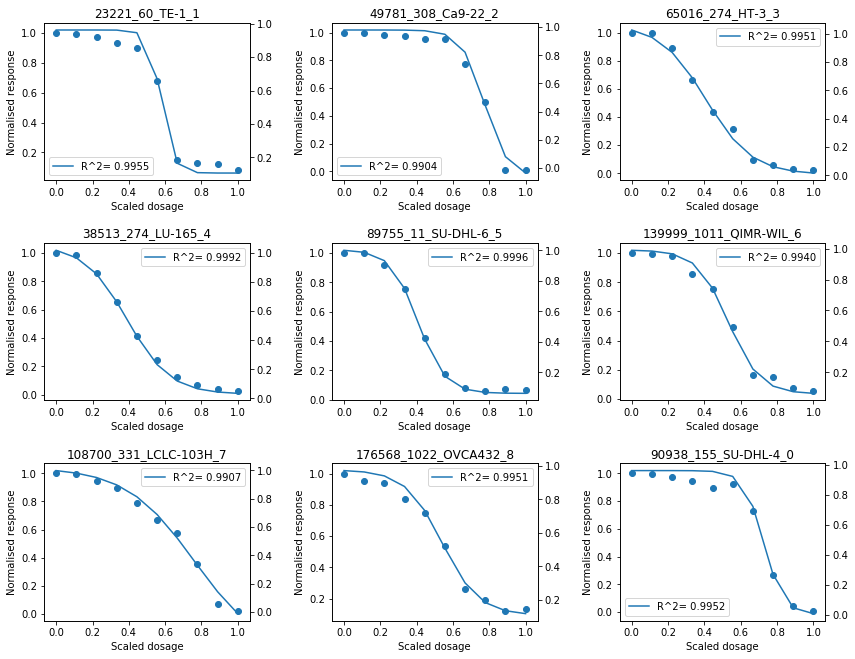

In [366]:
df = df4
max_int = len(df.index)
rand_int = np.random.randint(0, max_int, 9)
print(df.index[rand_int])

show_response_curves(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns = response_norm, 
                     start_index=0, indexes=df.index[rand_int],
                    fitting_function = sigmoid_4_param, fitting_parameters ="fitting_param")
#ind 59019???

Int64Index([56384, 166653, 130053, 139119, 98043, 142957, 21518, 131335,
            42217],
           dtype='int64')


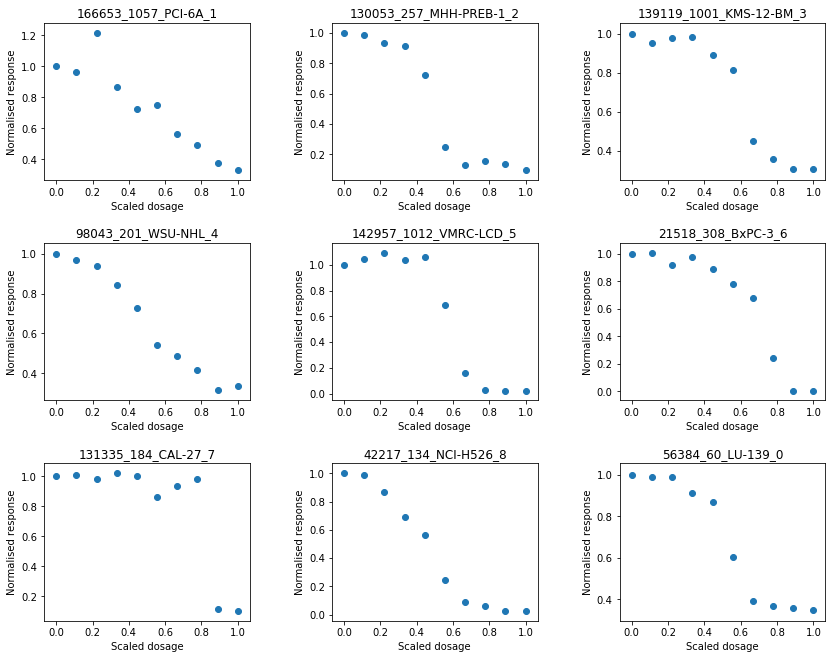

In [341]:
# df = df3
max_int = len(df.index)
rand_int = np.random.randint(0, max_int, 9)
print(df.index[rand_int])

show_response_curves(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns= response_norm, 
                     indexes=df.index[rand_int])
#166653

Int64Index([113041, 43218, 38688, 93067, 153062, 131321, 77980, 99684, 37180], dtype='int64')


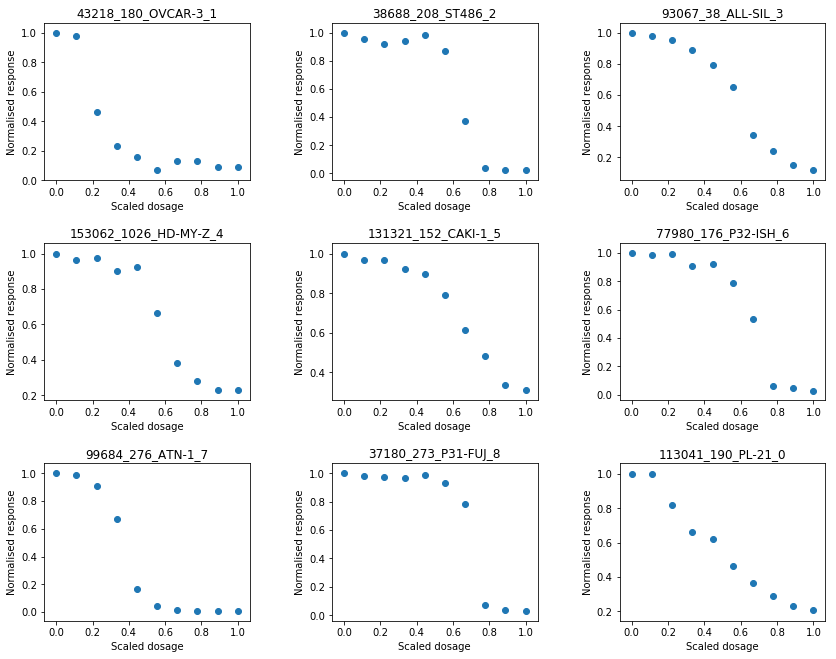

In [327]:
df = df3
max_int = len(df.index)
rand_int = np.random.randint(0, max_int, 9)
print(df.index[rand_int])

show_response_curves(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns= response_norm, 
                     indexes=df.index[rand_int])
#[12568 48962 59336 45367 36194   236  5120   614 23614]

### Fitting curves

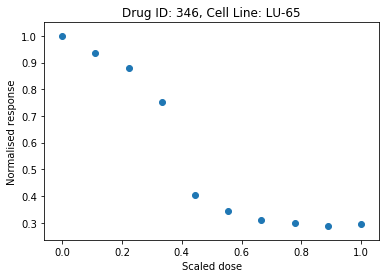

In [32]:
#good example
drug_id = 346
cell_line = "LU-65"
good = drug_curves[(drug_curves["DRUG_ID"]==drug_id)&(drug_curves["CELL_LINE_NAME"]== cell_line)]

plt.scatter(good.loc[good.index[0], conc_columns].values.astype(np.float32), 
            good.loc[good.index[0], response_norm].values.astype(np.float32))
plt.xlabel("Scaled dose")
plt.ylabel("Normalised response")
plt.title("Drug ID: %d, Cell Line: %s" % (drug_id, cell_line));

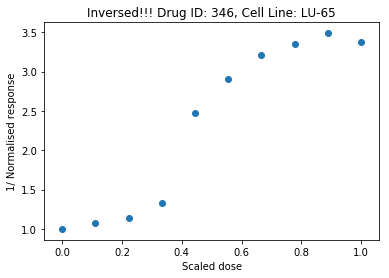

In [33]:
# good example
drug_id = 346
cell_line = "LU-65"
good = drug_curves[(drug_curves["DRUG_ID"]==drug_id)&(drug_curves["CELL_LINE_NAME"]== cell_line)]
x = good.loc[good.index[0], conc_columns].values.astype(np.float32),
y = 1/good.loc[good.index[0], response_norm].values.astype(np.float32)
plt.scatter(x, y)
plt.xlabel("Scaled dose")
plt.ylabel("1/ Normalised response")
plt.title("Inversed!!! Drug ID: %d, Cell Line: %s" % (drug_id, cell_line));

In [111]:
def fsigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

def sigmoid_Vis(x, p, s):
    """ x - dosage [0, 1],
    p - position,
    s - shape parameter,
    """
    return 1.0 / (1.0 + np.exp(-(x-p)/s))

def sigmoid_4_param(x, x0, L, k, b):
    y = 1/ (L + np.exp(-k*(x-x0)))+b
    return y

def sigmoid_3_param(x, x0, k, b):
    y = 1/ (1 + np.exp(-k*(x-x0)))+b
    return y


def logistic4(x, A, B, C, D):
    """ https://people.duke.edu/~ccc14/pcfb/analysis.html
    4PL logistic equation."""
    return ((A-D)/(1.0+((x/C)**B))) + D

def ll4(x, b, c, d, e):
    ''' https://gist.github.com/yannabraham/5f210fed773785d8b638
    This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

def ll4_R(x, b, c, d, e):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
    """
    return c + (d-c)/(1+np.exp(b*np.log(x)- e))


def fit_curve_fit(fitting_function, x, y, parameters_guess=[], to_plot = False):
    parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess)
    x2 = np.linspace(0, 1, 10)
    y2 = fitting_function(x2, *parameters)
    r2 = r2_score(y, y2)

    if to_plot:
        print("Fitting parameters:", *parameters)
        plt.scatter(x, y)
        plt.plot(x, y2, "blue", label = "R^2= %0.5f"%r2)   
        plt.title('Least-squares fit')
        plt.legend();
    return r2, parameters
        
def residuals(p, x, y, function_to_fit):
    """Deviations of data from fitted curve"""
    err = y-function_to_fit(x, *p)
    return err

def fit_lsq(function_to_fit, x, y, parameters_guess =[], to_plot = False):
    param_lsq = leastsq(residuals, parameters_guess, args=(x, y, function_to_fit))
    y2 = function_to_fit(x, *param_lsq[0])
    r2 = r2_score(y, y2)
    if to_plot:
        print("Fitting parameters:", *param_lsq[0])
        plt.scatter(x, y)
        plt.plot(x, y2, "blue", label = "R^2= %0.5f"%r2)   
        plt.title('Least-squares fit')
        plt.legend();
    return r2

In [35]:
# Inverted response
x = good.loc[good.index[0], conc_columns].values.astype(np.float32)
y = 1/good.loc[good.index[0], response_norm].values.astype(np.float32)

# fit_curve_fit(sigmoid_Vis, x, y, parameters_guess=[1, 5], to_plot = True)
# fit_lsq(x, y, sigmoid_Vis, parameters_guess=[1, 5], to_plot = True)

Fitting parameters: -4082539.0283247484 19931124.939608537


-3.2823075590826534e-08

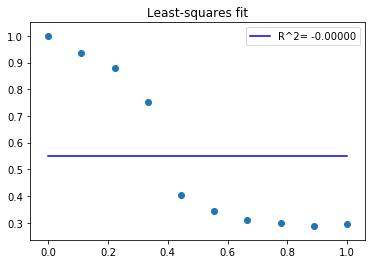

In [36]:
# Normal response
x = good.loc[good.index[0], conc_columns].values.astype(np.float32)
y = good.loc[good.index[0], response_norm].values.astype(np.float32)

#bounds are set as ([low_a,low_b],[high_a,high_b])
fit_curve_fit(sigmoid_Vis, x, y, parameters_guess=[1, 0.5], to_plot = True)

Fitting parameters: 7.523205551887484 0.2970497766424104 0.9466672350493502 0.36792284396941893


0.9917192755127807

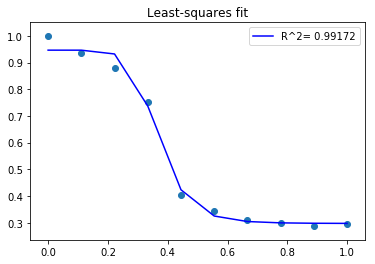

In [37]:
p0 = [max(y), np.median(x),1,min(y)]
fit_curve_fit(ll4, x, y, parameters_guess =p0, to_plot = True)

Fitting parameters: 0.3441752450702188 1.5128399848595575 -18.255477855267515 0.2997005952603317


0.9935016475653727

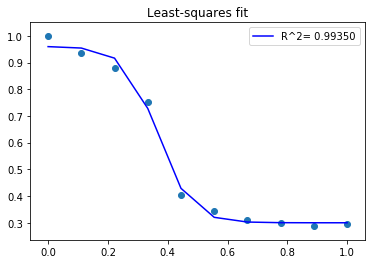

In [38]:
p0 = [max(y), np.median(x),1,min(y)]
fit_curve_fit(sigmoid_4_param, x, y, p0, to_plot = True)

Fitting parameters: 0.2782605164354585 -5.978300508020848 0.2331103208874468


0.9552315630039333

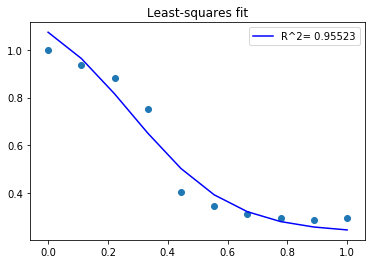

In [39]:
p0 = [max(y), np.median(x),min(y)]
fit_curve_fit(sigmoid_3_param, x, y, p0, to_plot = True)

Fitting parameters: 0.2970526941738411 -7.523259893217766 0.3679193144976095 0.9466692800576376


0.9917192801263175

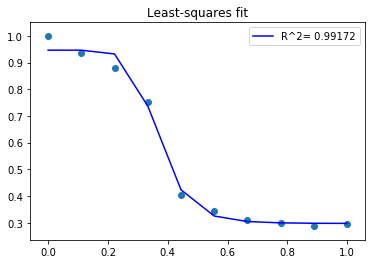

In [40]:
fit_lsq(logistic4, x, y, parameters_guess =[0, 1, 1, 1], to_plot = True)

Fitting parameters: 7.527285878644068 0.2970845477543197 0.9466496136230979 -7.526469821501663


0.9917192776183669

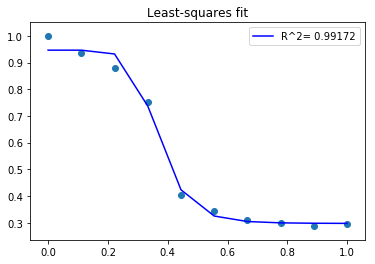

In [41]:
fit_lsq(ll4_R, x, y, parameters_guess =[max(y), np.median(x),1,min(y)], to_plot = True)

### Comparing models

In [126]:
x = good.loc[good.index[0], conc_columns].values.astype(np.float32)
y = good.loc[good.index[0], response_norm].values.astype(np.float32)


In [127]:
print("fsigmoid R2 % 0.4f"% fit_curve_fit(fsigmoid, x, y,parameters_guess=[1, 0.5])[0])
print("sigmoid_Vis R2 % 0.4f"% fit_curve_fit(sigmoid_Vis, x, y,parameters_guess=[1, 0.5])[0])
print("sigmoid_3_param R2 % 0.4f"% fit_curve_fit(sigmoid_3_param, x, y,parameters_guess= [max(y), np.median(x), min(y)])[0])
print("sigmoid_4_param R2 % 0.4f"% fit_curve_fit(sigmoid_4_param, x, y, parameters_guess= [max(y), np.median(x), 1, min(y)])[0])
# print("logistic4 R2 % 0.4f"% fit_lsq(logistic4,x, y,parameters_guess =[0, 1, 1, 1]))
print("logistic4 R2 % 0.4f"% fit_curve_fit(logistic4, x, y, parameters_guess =[0, 1, 1, 1])[0])
print("LL4 R2 % 0.4f"% fit_curve_fit(ll4_R, x, y,  parameters_guess= [max(y), np.median(x), 1, min(y)])[0])

fsigmoid R2  0.8476
sigmoid_Vis R2 -0.0000
sigmoid_3_param R2  0.9552
sigmoid_4_param R2  0.9935
logistic4 R2  0.9917
LL4 R2  0.9917


In [44]:
from tqdm import tqdm

In [149]:
def fit_curve_fit_column(df, indexes):
    
    r2_scores = np.zeros(len(indexes))
    X = df.loc[indexes, conc_columns].values.astype(np.float32)
    Y = df.loc[indexes, response_norm].values.astype(np.float32)
    fitting_parameters = [None]*len(indexes)
    
    for i in tqdm(range(len(indexes))):
        x = X[i, :]
        y = Y[i, :]
        try:
            r2_scores[i], fitting_parameters[i] = fit_curve_fit(sigmoid_4_param, x, y, parameters_guess= [max(y), np.median(x), 1, min(y)])
            
        except:
            #print(indexes[i])
            r2_scores[i] = 0
    return r2_scores, fitting_parameters

In [143]:
df2 = df_filt.copy()#loc[df_filt.index[16085:16095], :].copy()

In [144]:
df2.shape

(52540, 53)

In [ ]:
%%time
#around 5 min
r2, fit_param = fit_curve_fit_column(df2, df2.index)
df2["fitting_r2"] = r2
df2["fitting_param"] = fit_param

In [152]:
df2.to_csv("fitted_drugs.csv")

In [153]:
df2[["CELL_LINE_NAME", 'DRUG_ID', "fitting_r2", "fitting_param"]].head()

,CELL_LINE_NAME,DRUG_ID,fitting_r2,fitting_param
13,HDQ-P1,344,0.966718,"[0.8100850234454133, 0.9892494988253149, -26.2..."
15,HDQ-P1,223,0.000000,None
22,HDQ-P1,272,0.000000,None
24,HDQ-P1,328,0.971011,"[0.43349267675921827, 3.3889844600858483, -164..."
28,HDQ-P1,136,0.975429,"[0.6313296496301274, 0.9282910696470076, -5.82..."


In [178]:
df2[df2["fitting_r2"]==0].shape[0]

13133

In [179]:
fitted = df2[df2["fitting_r2"]!=0]

In [230]:
df2["dif_first"]=abs(df2[response_norm[0]] - df2[response_norm[1]])
df2["dif_last"]=abs(df2[response_norm[-2]] - df2[response_norm[-1]])

In [263]:
#r2>0.97 27711
fitted2 = df2[(df2["fitting_r2"]>0.98)&(df2[response_norm[-3]]<0.3)
              &(df2[response_norm[1]]>0.9) &(df2[response_norm[2]]>0.9)
              &(df2['dif_first']<0.02) & (df2['dif_last']<0.03)]
fitted2.shape

(1122, 57)

[ 961  504  510  218  529  497  372   43 1001]


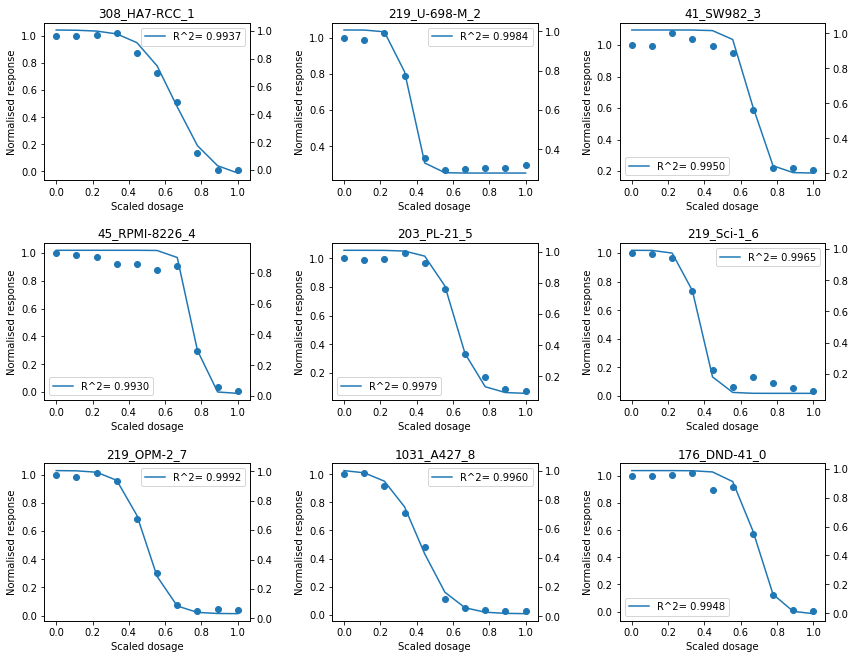

In [264]:
df = fitted2
max_int = len(df.index)
rand_int = np.random.randint(0, max_int, 9)
print(rand_int)

show_response_curves(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, y_columns= response_norm, 
                     start_index=0, indexes=df.index[rand_int],
                    fitting_function =sigmoid_4_param, fitting_parameters ="fitting_param")

### Useful

In [ ]:
xdata = np.array([400, 600, 800, 1000, 1200, 1400, 1600])
ydata = np.array([0, 0, 0.13, 0.35, 0.75, 0.89, 0.91])

def fsigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

popt, pcov = curve_fit(fsigmoid, xdata, ydata, method='dogbox', bounds=([0., 600.],[0.01, 1200.]))
plt.scatter(xdata, ydata)
plt.plot(xdata, fsigmoid(xdata, *popt));

In [ ]:
r2_scores= []
guesses = np.linspace(-2,2,20)
for i in guesses:
    
    p0 = [i, 0.1]

    popt, pcov = curve_fit(fsigmoid, xdata_log, ydata, p0=p0, method='dogbox')
    y_fitted = fsigmoid(xdata_log, *popt) 
    r2 = r2_score(ydata, y_fitted)
    r2_scores.append(abs(r2))  
    
plt.scatter(guesses, r2_scores);
#but this parameter i = p should correspond to IC50! It means that it should be somewhere close to 0.4 
#as it comes from the visual analysis of the graph

In [ ]:
r2_scores= []
guesses = np.linspace(0,20,40)
for i in guesses:
    
    p0 = [0.4, i]

    popt, pcov = curve_fit(fsigmoid, xdata, ydata, p0=p0, method='dogbox')
    y_fitted = fsigmoid(xdata, *popt) 
    r2 = r2_score(ydata, y_fitted)
    r2_scores.append(abs(r2))  
    
plt.scatter(guesses, r2_scores);

In [ ]:
plt.plot(guesses, r2_scores);


In [ ]:
https://biopython.org/DIST/docs/api/Bio.phenotype.pm_fitting-pysrc.html

In [ ]:
Filtering logics:
    1. first values of y>1 => filter out
    2. last values of y >0.9 => filter out

In [ ]:
https://jbhender.github.io/Stats506/F18/GP/Group16.html

In [ ]:
https://www.futuremedicine.com/doi/pdf/10.2217/pgs.16.15

In [ ]:
drug_332_log[response_norm]=np.log(drug_332_log[response_norm])

In [ ]:
drug_332_short = drug_332['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID',
       'DRUGID_COSMICID', 'FOLD_DILUTION', 'MAX_CONC', 'fd_num_0', 'fd_num_1',
       'fd_num_2', 'fd_num_3', 'fd_num_4', 'fd_num_5', 'fd_num_6', 'fd_num_7',
       'fd_num_8', 'fd_num_9', 'norm_cells_0', 'norm_cells_1', 'norm_cells_2',
       'norm_cells_3', 'norm_cells_4', 'norm_cells_5', 'norm_cells_6',
       'norm_cells_7', 'norm_cells_8', 'norm_cells_9'].columns

In [ ]:
conc = np.array(drug_curves["MAX_CONC"].unique())
conc.min(), conc.max()

In [ ]:
drug_id=238
conc = np.array(drug_curves[drug_curves["DRUG_ID"]==drug_id]["MAX_CONC"].unique())

In [ ]:
several_conc =[]
for drug_id in drug_curves["DRUG_ID"].unique():
    conc = np.array(drug_curves[drug_curves["DRUG_ID"]==drug_id]["MAX_CONC"].unique())
    if len(conc)>1:
        several_conc.append(drug_id)
        print("Drug id: %d, Available concentrations: %d, min concetraion: %0.2f, max concetration: %0.2f" % (drug_id, len(conc), conc.min(), conc.max()))

In [ ]:
len(several_conc)

In [ ]:
drug_curves[drug_curves[conc_columns[-1]].isnull()][conc_columns]

In [ ]:
filter data drug vs different cells,
script to see which data are good, AUC, noise/data